# Exploration 3
## | 프로젝트: 카메라 스티커앱 만들기
### | 프로젝트 학습 과정
1. 스티커 구하기
- [스티커이미지 다운로드](https://www.flaticon.com/)
2. 얼굴 검출
3. 랜드마크 검출하기
4. 스티커 적용 위치 확인하기


5. 스티커 적용하기
- np.where 사용
- cv2.addweighted()

6. 문제점 찾아보기
- 얼굴 각도에 따라 스티커가 어떻게 변해야 하는지?
- 멀리서 촬영하면 왜 안 되는지? 
- 옆으로 누워서 촬영하면 왜 안 되는지?
- 스티커앱을 만들 때, 정확도가 얼마나 중요할까?

# 1. 이미지 불러오기

필요한 패키지를 불러와봅시다!

In [1]:
# 필요한 패키지
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import dlib
print("🌫🛸")

🌫🛸


이미지 경로:  /aiffel/aiffel/camera_sticker/images/kang.png


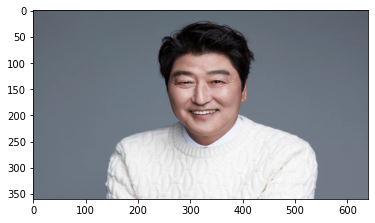

In [2]:
# 이미지 불러오기

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/kang.png'
print('이미지 경로: ', my_image_path)

img_bgr = cv2.imread(my_image_path) #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360)) # 640x360의 크기로 Resize
img_show = img_bgr.copy() #- 출력용 이미지 별도 보관

# 색상 이미지로 전환 BRG → RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

- 이미지 출처: [써브라임아티스트에이전시](https://www.sublimeartist.co.kr/post/song-kang-ho)

# 2. 얼굴 검출(Boundary Box)

In [3]:
detector_hog = dlib.get_frontal_face_detector() #- detector 선언

dlib_rects = detector_hog(img_rgb, 1) #- (image, num of img pyramid)

print(dlib_rects)

rectangles[[(236, 81) (390, 236)]]


rectangles[[(236, 81) (390, 236)]]


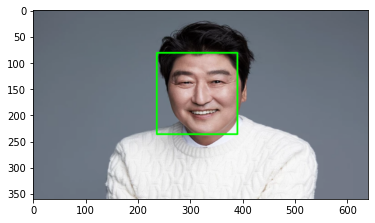

In [4]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 3. 얼굴 랜드마크 (Face Landmark)
- Face Landmark Localization 기술을 사용해 봅시다!
- face landmark는 detection의 결과물인 bounding box로 crop한 이미지를 이용합니다!

**Object Keypoint Estimation**
1. top-down: bounding box를 찾고 box 내부의 keypoint를 예측
2. bottom-up: 이미지 전체의 keypoint를 먼저 찾고, point 관계로 군집화해서 box 생성

**Dlib landmark localization**

잘라진 얼굴 이미지에서 68개의 이목구비 위치를 찾는다
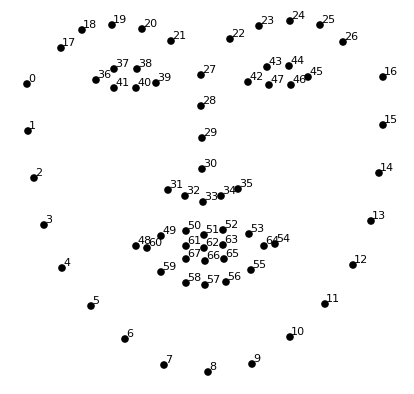
<Dlib에 사용 되는 랜드마크 순서>

- Dlib의 제공되는 모델 중 weight file을 다운로드하여 사용해 봅시다!
- $ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
- mv shape_predictor_68_face_landmarks.dat.bz2 ~

## 3-(1) landmark 모델

In [5]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


## 3-(2) landmark_predictor
- RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection을 반환합니다.

In [6]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


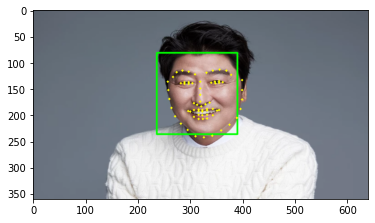

In [7]:
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 4. 스티커 적용 위치 확인하기

## 연습) 머리 위에 왕관을 씌어서 연습해 봅니다! 

먼저, 머리 위에 왕관을 씌어볼 예정이니
- 랜드마크를 기준으로 '눈썹 위 얼굴 중앙'에 스티커를 씌우면 좋을 것 같아요!
- 그런데 사진마다 얼굴 위치와 카메라의 거리에 따라 픽셀 x가 다르기 때문에 비율로 계산을 해줘야 할 것 같습니다!

1. 스티커 위치
- x = x(nose)
- y = y(nose) - width/2

2. 스티커 크기
- width = height = width(bbox)

In [8]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(319, 174)
(x,y) : (319,97)
(w,h) : (155,155)


제가 준비한 송강호 이미지에 맞는 픽셀 값이 나왔네요!
- 코의 위치(좌표)는 319, 97
- 스티커 크기는 155, 155

입니다!

(155, 155, 3)


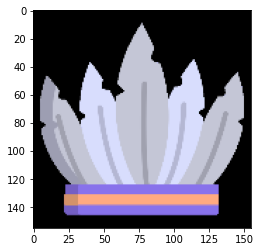

In [9]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/feather.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

- 준비해 둔 스티커 이미지를 읽어서 송강호 얼굴 위에 적용을 해보겠습니다!
- 원본 이미지에 스티커 이미지를 추가하기 위해 x, y 좌표를 w, h로 조정을 하였습니다. 시작점은 top-left 좌표이기 때문에 (x, y) 좌표를 기준으로 계산합니다.💻

In [10]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (242,-58)


- 😨 어머나! y 좌표가 음수가 나왔네요.
- 스티커의 y좌표가 음수가 나왔다는 것은, 영역 밖으로 튀어나왔다는 소리 같습니다.
- opencv의 데이터는 numpy ndarray 형태의 데이터이기 때문에 음수를 예외 처리를 해줘야 합니다!

In [11]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(97, 155, 3)


In [12]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (242,0)


# 5. 스티커 적용하기

In [13]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

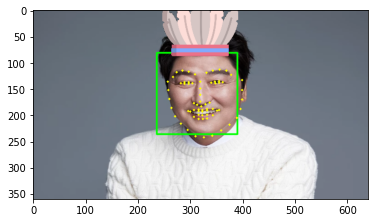

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

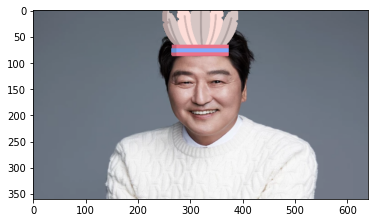

In [15]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

왕관 대신 인디언 깃을 씌어보았습니다!
제가 5번은 넘게 본 기생충 영화의 한 장면 입니다. 🙌

<img src = "http://file3.instiz.net/data/cached_img/upload/2020/10/04/0/57c8448697e51fc4b062a99e5ca0d6e8_mp4.gif" width="400px" align="left">

## 실전) 고양이 수염 붙여보기

이미지 경로:  /aiffel/aiffel/camera_sticker/images/woo.jpg


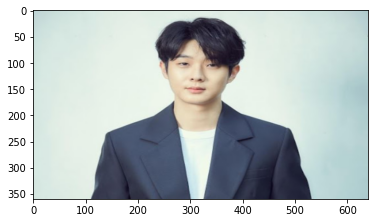

In [17]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/woo.jpg'
print('이미지 경로: ', my_image_path)

img_bgr = cv2.imread(my_image_path) #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360)) # 640x360의 크기로 Resize
img_show = img_bgr.copy() #- 출력용 이미지 별도 보관

# 색상 이미지로 전환 BRG → RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(259, 68) (366, 175)]]


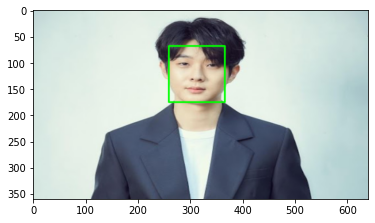

In [48]:
detector_hog = dlib.get_frontal_face_detector() #- detector 선언
dlib_rects = detector_hog(img_rgb, 1) #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [49]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


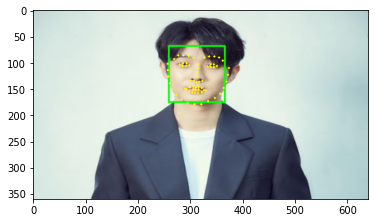

In [50]:
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [51]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(313, 127)
(x,y) : (313,127)
(w,h) : (108,108)


- 스티커의 좌표는 landmark인 코 위에 가야하기 때문에 x, y 좌표 모두 landmark[30]을 기준으로 계산하였다.

(108, 108, 3)


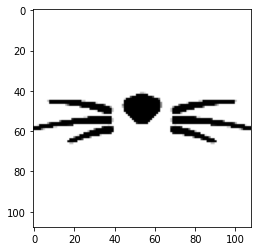

In [52]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

- 스티커 이미지는 고양이 수염! 🐱

In [53]:
refined_x = x - w // 2  # left
refined_y = y - h // 2     # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (259,73)


- 수염 스티커는 landmark로 잡은 코 위에 올라가면 되기 때문에 위치를 (x, y) 좌표에서 나누기 2로 설정해주었다.

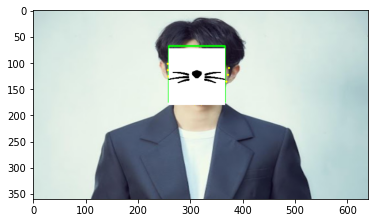

In [56]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 스티커 파일이 png임에도 불구하고 흰 배경까지 갖고 출력이 되었습니다. 흰 배경을 없애기 위해서는
- np.where(**img_sticker==255**,sticker_area,img_sticker).astype(np.uint8) 해당 방법이 있다.
- numpy의 unit8은 2^8개 개수 만큼 정수를 제공하는 자료형이며, 0~255까지의 bit을 갖게 된다.
- img_sticker==255로 설정하여 불투명한 부분과 투명한 부분의 area를 설정해준다.

📌참고 [Numpy의 데이터 타입](https://kongdols-room.tistory.com/53)

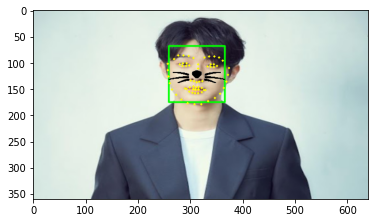

In [55]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

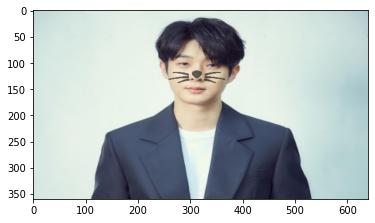

In [45]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area, cv2.addWeighted(img_sticker, 0.6, sticker_area, 0.4, 0)).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 최우식 얼굴에 고양이 수염을 붙였습니다!👏

# 6. 문제점 찾아보기

## 6.(1) 얼굴 각도에 따른 스티커 변화
### 살짝 측면일 때

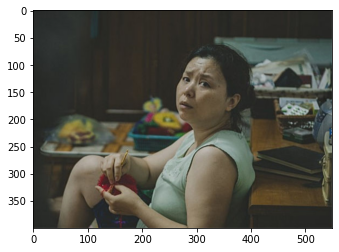

In [18]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/mom.jpg'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (550, 400))

#이미지 색깔 RGB로 변경
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
img_show = img_bgr.copy()
img_try = img_bgr.copy()

plt.imshow(img_rgb)
plt.show()

rectangles[[(247, 92) (354, 199)]]


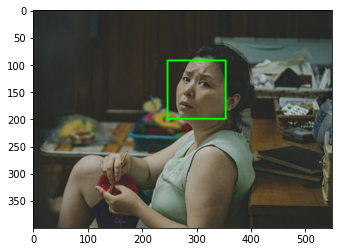

In [19]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   

# 얼굴 영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


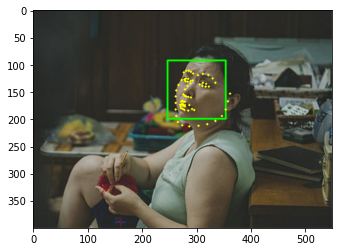

In [20]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 측면이지만 눈썹, 눈, 코, 입, 턱 부분까지 인식이 잘 되었다.

### 기존 방식 스티커 위치

In [21]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) #nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(279, 145)
(x,y) : (279,145)
(w,h) : (108,108)


In [22]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv.imread(sticker_path)
img_sticker = cv.resize(img_sticker, (w,h))
print (img_sticker.shape)

(108, 108, 3)


In [23]:
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (225,91)


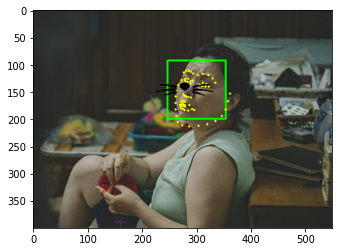

In [24]:
sticker_first = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 0, img_sticker, sticker_first).astype(np.uint8)

plt.imshow(cv.cvtColor(img_show, cv.COLOR_BGR2RGB))
plt.show()

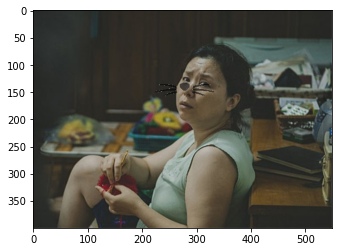

In [25]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area, cv2.addWeighted(img_sticker, 0.6, sticker_area, 0.4, 0)).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 기존 정면 사진 때 사용했던 방법으로 스티커 위치를 적용했더니 스티커가 코보다 좀 위에 가있고, 얼굴을 가리기도 한다.
- 이 스티커를 이미지에 맞게 **이동, 각도를 변환** 시켜주려고 한다.

### 스티커 이동 및 각도 조절

In [26]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(281, 158)
(x,y) : (281,158)
(w,h) : (108,108)


In [27]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv.imread(sticker_path)
img_sticker = cv.resize(img_sticker, (w,h))
print (img_sticker.shape)

(108, 108, 3)


In [28]:
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (227,104)


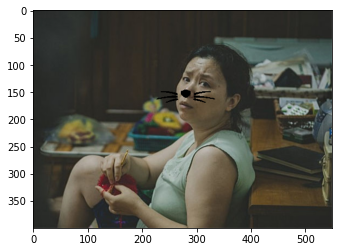

In [29]:
sticker_first = img_try[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_try[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 0, img_sticker, sticker_first).astype(np.uint8)

plt.imshow(cv.cvtColor(img_try, cv.COLOR_BGR2RGB))
plt.show()

- landmark를 30에서 33으로 내려주니 코의 위치가 맞다. 이제 각도를 조금 돌려보고 싶다.

In [42]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
sticker = cv.imread(sticker_path)
sticker = cv.resize(sticker, (w,h))
height, width, channel = sticker.shape

In [43]:
matrix = cv.getRotationMatrix2D((width/2, height/2), 30, 1)
dst = cv.warpAffine(sticker, matrix, (width, height))

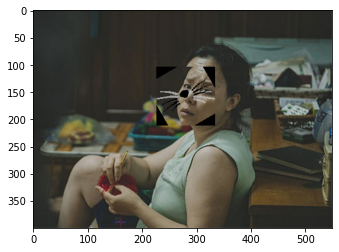

In [45]:
sticker_first = img_try[refined_y:refined_y+dst.shape[0], refined_x:refined_x+dst.shape[1]]
img_try[refined_y:refined_y+dst.shape[0], refined_x:refined_x+dst.shape[1]] = \
    np.where(dst == 0, dst, sticker_first).astype(np.uint8)

plt.imshow(cv.cvtColor(img_try, cv.COLOR_BGR2RGB))
plt.show()

- 문제 해결 방법은 많이 찾아 보았는데 자꾸 Died가 되어 프로젝트 제출 이후에 해결해보겠습니다...

### 완전 측면일 때

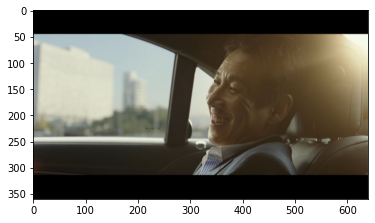

In [121]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/lee.jpg'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (640, 360))

#이미지 색깔 RGB로 변경
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
img_show = img_bgr.copy()

plt.imshow(img_rgb)
plt.show()

rectangles[]


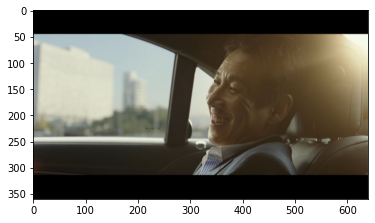

In [122]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   

# 얼굴 영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- rectangles[]로 얼굴을 인식하지 못한다. 

## 6.(2) 멀리서 촬영할 때

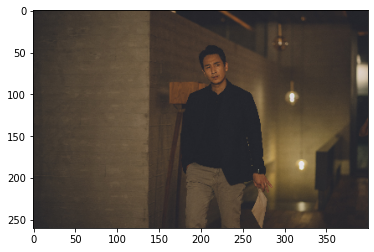

In [123]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/lee2.jpg'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (400, 260))

#이미지 색깔 RGB로 변경
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
img_show = img_bgr.copy()

plt.imshow(img_rgb)
plt.show()

rectangles[[(197, 54) (233, 90)]]


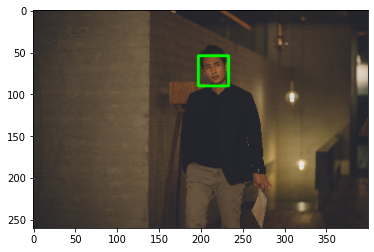

In [124]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   

# 얼굴 영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 인물이 멀리 있는 사진도 얼굴을 잘 인식하는 것으로 보인다.

## 6.(3) 옆으로 누워 있는 사진

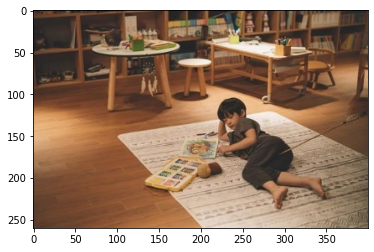

In [125]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/dasong.jpeg'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (400, 260))

#이미지 색깔 RGB로 변경
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
img_show = img_bgr.copy()

plt.imshow(img_rgb)
plt.show()

rectangles[]


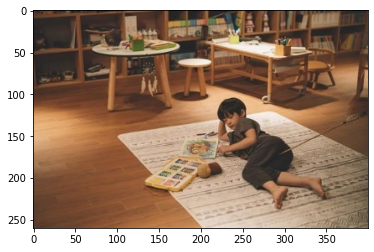

In [126]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   

# 얼굴 영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 옆으로 누워있는 사진은 인식이 잘 되지 않는다. 다른 이미지 하나만 더 적용해보겠다.

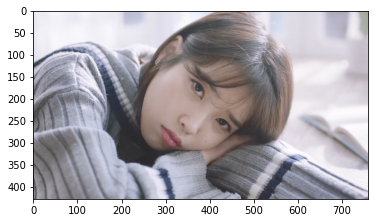

In [127]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/iu.jpg'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (760, 427))

#이미지 색깔 RGB로 변경
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
img_show = img_bgr.copy()

plt.imshow(img_rgb)
plt.show()

rectangles[]


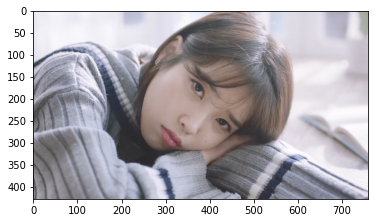

In [128]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   

# 얼굴 영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 마찬가지로 옆으로 누워 있는 사진은 얼굴 인식이 잘 되지 않는다.

왜 그럴까?
- detector를 구현하는 코드가 정면을 기준으로 설정해서 그런 듯 하다.

## (4) 스티커앱을 만들 때, 정확도의 중요성

- 스티커앱을 만드는 해당 프로젝트의 목표는 '얼굴 인식을 얼마나 정확하게 구현할 수 있는지?'인 것 같다.
- 얼굴 인식 기술은 모두가 알다시피 많이 상용화 되었습니다.
- 체온 측정 기기, Face ID, 얼굴 인식 CCTV 등
- 딥러닝 기반 얼굴 인식 기술의 정확도는 계속 발전하여 99.9%까지 달성했다는 논문을 찾아보았음
- 오늘은 정적인 이미지를 통하여 간단하게 프로젝트를 해보며, 다양한 자료를 볼 수 있었습니다.

# 정리

아쉬운 점
- 각도나 사람 얼굴 크기에 따른 다양한 스티커 적용 방법은 아직 모른다.
- 이미지로만 구현을 해보았고, 움직이는 영상(각도가 계속 바뀌기 때문에)으로는 아직 시도해 보지 못했다.

**오늘 프로젝트를 통해 앞으로 무엇을 공부하면 좋을지?**
1. OpenCV [이미지 변형](https://dsbook.tistory.com/184), 이미지를 변형하는 다양한 기능
2. 구글 [Face Detection](https://developers.google.com/ml-kit/vision/face-detection) 튜토리얼을 통해 이미지, 영상 등의 얼굴 인식, 각도 변환에 따른 구현 방법 살펴보기